**Assignment 1: Object Detection for Wildlife Conservation - Detecting Waterfowl in UAV Thermal Imagery**

**Team members: Team members:
 Thota Bhuvana Chandra (10001026),
 Rachitha Chandra Bhanu(10000726)
 ,Sai surya mada(10000982)**



**1. Dataset Loading & Annotation Reading**

In [ ]:
import os
from glob import glob
import pandas as pd

DATA_ROOT = "Portfolio_1_Cv"
  

POS_DIR = os.path.join(DATA_ROOT, "01_Positive_Image")
NEG_DIR = os.path.join(DATA_ROOT, "03_Negative_Images")

# the CSV file inside: 02_Groundtruth_Label_for_Positive_Images
CSV_PATH = os.path.join(DATA_ROOT, "02_Groundtruth_Label_for_Positive_Images",
                        "Bounding_Box_Label.csv")  

df = pd.read_csv(CSV_PATH)

# column names from your screenshot:
#   imageFilename, x(column), y(row), width, height
df.rename(columns={
    "imageFilename": "imageFilename",
    "x(column)": "x",
    "y(row)": "y",
    "width": "width",
    "height": "height"
}, inplace=True)

print(df.head())
print("Total annotation rows:", len(df))

# group annotations by image
grouped = df.groupby("imageFilename")
pos_image_names = sorted(grouped.groups.keys())

print("Positive images with labels:", len(pos_image_names))

# list ALL negative images (no labels)
neg_image_paths = sorted(glob(os.path.join(NEG_DIR, "*.tif"))) + \
                  sorted(glob(os.path.join(NEG_DIR, "*.tiff"))) + \
                  sorted(glob(os.path.join(NEG_DIR, "*.jpg"))) + \
                  sorted(glob(os.path.join(NEG_DIR, "*.jpeg"))) + \
                  sorted(glob(os.path.join(NEG_DIR, "*.png")))

print("Negative images:", len(neg_image_paths))


               imageFilename    x   y  width  height
0  20180322_101536_979_R.tif  127  11      7       7
1  20180322_101536_979_R.tif  174  32      7       7
2  20180322_101536_979_R.tif  178  19      7       7
3  20180322_101536_979_R.tif  199  31      7       7
4  20180322_101536_979_R.tif  223  51      7       7
Total annotation rows: 8975
Positive images with labels: 355
Negative images: 187


**2. Custom PyTorch Dataset Class**

In [57]:
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms.functional as F
import torch
import random

class WaterfowlThermalDataset(Dataset):
    """
    Uses:
      - Positive images from 01_Positive_Image with boxes from CSV
      - Negative images from 03_Negative_Images with NO boxes
    """
    def __init__(self, pos_image_names, grouped_df,
                 pos_dir, neg_paths, transforms=None):
        self.pos_image_names = pos_image_names     # list of filenames (e.g. 20180322_101536_979_R.tif)
        self.grouped = grouped_df                  # groupby object for CSV
        self.pos_dir = pos_dir
        self.neg_paths = neg_paths                 # full paths for negatives
        self.transforms = transforms

        # build a unified index list: first all positives, then negatives
        self.num_pos = len(self.pos_image_names)
        self.num_neg = len(self.neg_paths)

    def __len__(self):
        return self.num_pos + self.num_neg

    def _load_positive(self, idx):
        fname = self.pos_image_names[idx]
        img_path = os.path.join(self.pos_dir, fname)

        # load thermal image as grayscale, then make 3 channels
        img = Image.open(img_path).convert("L")
        img = F.to_tensor(img).repeat(3, 1, 1)

        ann = self.grouped.get_group(fname)
        boxes = []
        labels = []

        for _, row in ann.iterrows():
            x = float(row["x"])
            y = float(row["y"])
            w = float(row["width"])
            h = float(row["height"])
            boxes.append([x, y, x + w, y + h])
            labels.append(1)   # class 1 = waterfowl

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx])
        }
        return img, target

    def _load_negative(self, neg_idx):
        img_path = self.neg_paths[neg_idx]

        img = Image.open(img_path).convert("L")
        img = F.to_tensor(img).repeat(3, 1, 1)

        boxes = torch.zeros((0, 4), dtype=torch.float32)
        labels = torch.zeros((0,), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([self.num_pos + neg_idx])
        }
        return img, target

    def __getitem__(self, idx):
        if idx < self.num_pos:
            img, target = self._load_positive(idx)
        else:
            neg_idx = idx - self.num_pos
            img, target = self._load_negative(neg_idx)

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target


**3. Data Augmentation Pipeline**

In [58]:
class ComposeTransforms:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, target):
        for t in self.transforms:
            img, target = t(img, target)
        return img, target


class RandomHorizontalFlip:
    def __init__(self, p=0.7):
        self.p = p

    def __call__(self, img, target):
        if random.random() < self.p:
            img = F.hflip(img)
            w = img.shape[2]
            boxes = target["boxes"]
            if boxes.shape[0] > 0:
                x_min = w - boxes[:, 2]
                x_max = w - boxes[:, 0]
                boxes[:, 0] = x_min
                boxes[:, 2] = x_max
                target["boxes"] = boxes
        return img, target
    
class RandomBlur:
    def __init__(self, p=0.4):
        self.p = p
    def __call__(self, img, target):
        if random.random() < self.p:
            img = F.gaussian_blur(img, kernel_size=3)
        return img, target




def get_train_transforms():
    return ComposeTransforms([
        RandomHorizontalFlip(0.5),
        RandomBlur(0.3)
        
        
    ])





def get_test_transforms():
    return ComposeTransforms([])


**4. Train/Validation/Test Split + DataLoaders**

In [59]:
from torch.utils.data import random_split, DataLoader

full_dataset = WaterfowlThermalDataset(
    pos_image_names=pos_image_names,
    grouped_df=grouped,
    pos_dir=POS_DIR,
    neg_paths=neg_image_paths,
    transforms=None  # we'll wrap with transforms below
)

N = len(full_dataset)
train_size = int(0.6 * N)
val_size   = int(0.2 * N)
test_size  = N - train_size - val_size

train_subset, val_subset, test_subset = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

class WrappedDataset(Dataset):
    def __init__(self, subset, transforms):
        self.subset = subset
        self.transforms = transforms

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        img, target = self.subset[idx]
        if self.transforms:
            img, target = self.transforms(img, target)
        return img, target

train_dataset = WrappedDataset(train_subset, get_train_transforms())
val_dataset   = WrappedDataset(val_subset,   get_test_transforms())
test_dataset  = WrappedDataset(test_subset,  get_test_transforms())


def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
 

print("Train:", len(train_dataset), "Val:", len(val_dataset), "Test:", len(test_dataset))


Train: 325 Val: 108 Test: 109


**5. Faster R-CNN Model Setup**

In [60]:
import torchvision
import torch
import torch.optim as optim

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_CLASSES = 2  # 1 background + 1 waterfowl class

def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
        weights="DEFAULT"
    )
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = \
        torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
            in_features, num_classes
        )
    return model

model = get_model(NUM_CLASSES).to(DEVICE)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.AdamW(params, lr=1e-4)


**6. Learning Rate Scheduler**

In [61]:
import torch.optim as optim

# optimizer (must be created after the model is created)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.AdamW(params, lr=1e-4)

# learning rate scheduler (controls LR decay over epochs)
lr_scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=5,   # reduce LR every 5 epochs
    gamma=0.1      # LR becomes LR * 0.1
)

print("Scheduler created.")


Scheduler created.


**7. Training Loop**

In [62]:
NUM_EPOCHS = 15
def train_one_epoch(model, data_loader, optimizer, device, epoch):
    model.train()
    running_loss = 0.0

    for imgs, targets in data_loader:
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += loss_value

    epoch_loss = running_loss / len(data_loader)
    print(f"Epoch {epoch}: loss = {epoch_loss:.4f}")
    return epoch_loss


for epoch in range(1, NUM_EPOCHS + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer, DEVICE, epoch)
    lr_scheduler.step()


Epoch 1: loss = 0.4358
Epoch 2: loss = 0.2655
Epoch 3: loss = 0.2481
Epoch 4: loss = 0.2403
Epoch 5: loss = 0.2204
Epoch 6: loss = 0.1965
Epoch 7: loss = 0.1859
Epoch 8: loss = 0.1796
Epoch 9: loss = 0.1845
Epoch 10: loss = 0.1788
Epoch 11: loss = 0.1763
Epoch 12: loss = 0.1730
Epoch 13: loss = 0.1758
Epoch 14: loss = 0.1778
Epoch 15: loss = 0.1742


**Saving the trained RCNN model**

In [63]:
torch.save(model, "faster_rcnn_full_model.pth")
print("Full model saved.")


Full model saved.


**8. mAP Computation (mAP@0.5)**

In [64]:
from torchvision.ops import box_iou
import numpy as np

def compute_map(model, data_loader, device, iou_thresh=0.5):
    model.eval()

    # Store all predictions
    all_scores = []
    all_tp_flags = []   # 1 for TP, 0 for FP
    total_gt = 0

    with torch.no_grad():
        for imgs, targets in data_loader:

            img = imgs[0].to(device)
            target = {k: v.to(device) for k, v in targets[0].items()}
            gt_boxes = target["boxes"]
            total_gt += len(gt_boxes)

            outputs = model([img])[0]
            pred_boxes = outputs["boxes"]
            scores = outputs["scores"]

            if len(pred_boxes) == 0:
                continue

            # IoU matrix
            if len(gt_boxes) > 0:
                ious = box_iou(pred_boxes, gt_boxes)  # [P, G]
            else:
                ious = None

            # Sort predictions by score (descending)
            sorted_idx = torch.argsort(scores, descending=True)
            pred_boxes = pred_boxes[sorted_idx]
            scores = scores[sorted_idx]

            matched_gt = set()

            for i in range(len(pred_boxes)):
                score = scores[i].item()
                all_scores.append(score)

                if len(gt_boxes) == 0:
                    all_tp_flags.append(0)
                    continue

                # Find GT with the highest IoU
                iou_vals = ious[i]
                max_iou, gt_idx = iou_vals.max(0)
                gt_idx = gt_idx.item()

                if max_iou >= iou_thresh and gt_idx not in matched_gt:
                    all_tp_flags.append(1)   # True Positive
                    matched_gt.add(gt_idx)
                else:
                    all_tp_flags.append(0)   # False Positive

    # Convert to numpy for PR curve computation
    all_scores = np.array(all_scores)
    all_tp_flags = np.array(all_tp_flags)

    # Sort by confidence scores
    sort_idx = np.argsort(-all_scores)
    all_scores = all_scores[sort_idx]
    all_tp_flags = all_tp_flags[sort_idx]

    tp_cum = np.cumsum(all_tp_flags)
    fp_cum = np.cumsum(1 - all_tp_flags)

    recall = tp_cum / (total_gt + 1e-6)
    precision = tp_cum / (tp_cum + fp_cum + 1e-6)

    # Compute AP = area under PR curve (11-point interpolation or continuous)
    ap = 0.0
    for t in np.linspace(0, 1, 101):
        p = precision[recall >= t].max() if np.any(recall >= t) else 0
        ap += p
    ap /= 101  # mean of sampled points

    print(f"mAP@{iou_thresh}: {ap:.4f}")
    return ap


In [65]:
map50 = compute_map(model, test_loader, DEVICE, iou_thresh=0.5)


mAP@0.5: 0.9082


**9. Precision, Recall, F1 Evaluation**

In [66]:
from torchvision.ops import box_iou

def evaluate_detection(model, data_loader, device, score_thresh=0.5, iou_thresh=0.5):
    model.eval()
    all_tp, all_fp, all_fn = 0, 0, 0

    with torch.no_grad():
        for imgs, targets in data_loader:
            img = imgs[0].to(device)
            target = {k: v.to(device) for k, v in targets[0].items()}

            outputs = model([img])[0]
            pred_boxes = outputs["boxes"]
            scores = outputs["scores"]

            # keep only high-confidence predictions
            keep = scores >= score_thresh
            pred_boxes = pred_boxes[keep]

            gt_boxes = target["boxes"]

            if len(pred_boxes) == 0 and len(gt_boxes) == 0:
                continue

            if len(pred_boxes) == 0 and len(gt_boxes) > 0:
                all_fn += len(gt_boxes)
                continue

            if len(pred_boxes) > 0 and len(gt_boxes) == 0:
                all_fp += len(pred_boxes)
                continue

            # Compute IoU matrix
            ious = box_iou(pred_boxes, gt_boxes)  # [num_pred, num_gt]

            # Greedy matching
            matched_gt = set()
            tp = 0
            for i in range(len(pred_boxes)):
                # Best IoU for this prediction
                iou_vals = ious[i]
                max_iou, j = iou_vals.max(0)
                j = j.item()
                if max_iou >= iou_thresh and j not in matched_gt:
                    tp += 1
                    matched_gt.add(j)

            fp = len(pred_boxes) - tp
            fn = len(gt_boxes) - tp

            all_tp += tp
            all_fp += fp
            all_fn += fn

    precision = all_tp / (all_tp + all_fp + 1e-6)
    recall = all_tp / (all_tp + all_fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)

    print(f"TP={all_tp}, FP={all_fp}, FN={all_fn}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"F1-score:  {f1:.3f}")

    return precision, recall, f1


precision, recall, f1 = evaluate_detection(model, test_loader, DEVICE)


TP=1259, FP=148, FN=117
Precision: 0.895
Recall:    0.915
F1-score:  0.905


**10. Ground Truth vs Prediction Visualization**

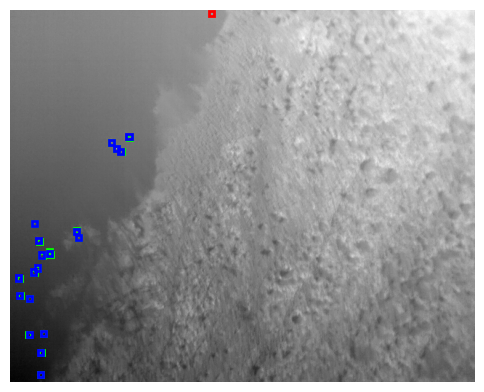

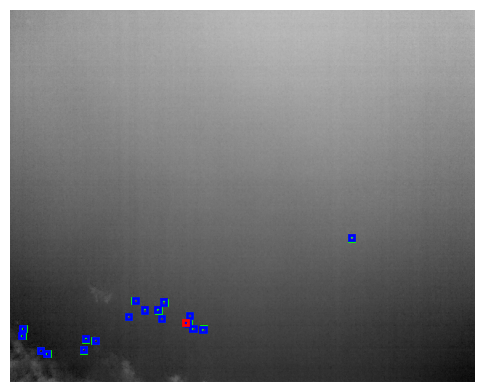

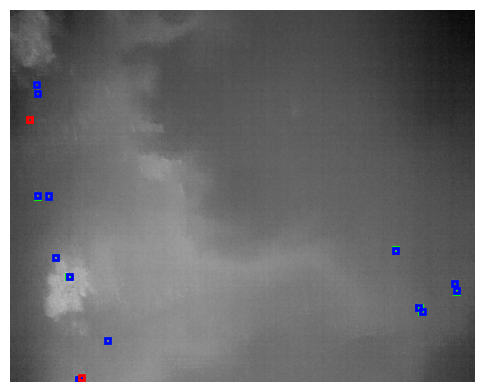

In [73]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import random

def show_detections(model, dataset, device, idx, score_thresh=0.5, iou_thresh=0.5):
    model.eval()
    img, target = dataset[idx]
    img_gpu = img.to(device)
    target_gpu = {k: v.to(device) for k, v in target.items()}

    with torch.no_grad():
        out = model([img_gpu])[0]

    pred_boxes = out["boxes"]
    scores = out["scores"]
    keep = scores >= score_thresh
    pred_boxes = pred_boxes[keep]

    gt_boxes = target_gpu["boxes"]

    # Match for TP/FP/FN marking
    ious = box_iou(pred_boxes, gt_boxes) if len(pred_boxes) > 0 and len(gt_boxes) > 0 else None
    matched_gt = set()
    tp_idx = set()
    if ious is not None:
        for i in range(len(pred_boxes)):
            iou_vals = ious[i]
            max_iou, j = iou_vals.max(0)
            j = j.item()
            if max_iou >= iou_thresh and j not in matched_gt:
                tp_idx.add(i)
                matched_gt.add(j)

    img_np = img.permute(1, 2, 0).cpu().numpy()
    plt.figure(figsize=(6, 6))
    plt.imshow(img_np, cmap="gray")

    # Draw GT boxes (green)
    for box in gt_boxes.cpu():
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        rect = patches.Rectangle((x1, y1), w, h, linewidth=2,
                                 edgecolor="lime", facecolor="none")
        plt.gca().add_patch(rect)

    # Draw predicted boxes: TP in blue, FP in red
    for i, box in enumerate(pred_boxes.cpu()):
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        color = "blue" if i in tp_idx else "red"
        rect = patches.Rectangle((x1, y1), w, h, linewidth=2,
                                 edgecolor=color, facecolor="none")
        plt.gca().add_patch(rect)

    plt.axis("off")
    plt.show()




# Pick 3 random unique indices from the test dataset
random_indices = random.sample(range(len(test_dataset)), 3)

for idx in random_indices:
    show_detections(model, test_dataset, DEVICE, idx)


**11. Testing on a Single Uploaded Image**

In [68]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms.functional as F
import torch

def detect_on_image(model, device, image_path, score_thresh=0.5):
    """
    Load an image from disk, run the detector, and visualize predictions.
    Works for your thermal .tif images.
    """
    model.eval()

    # 1. Load image (grayscale) and convert to tensor [3, H, W]
    img = Image.open(image_path).convert("L")
    img_tensor = F.to_tensor(img).repeat(3, 1, 1).to(device)

    with torch.no_grad():
        out = model([img_tensor])[0]

    pred_boxes = out["boxes"]
    scores = out["scores"]

    # Keep only predictions above threshold
    keep = scores >= score_thresh
    pred_boxes = pred_boxes[keep]
    scores = scores[keep]

    # 2. Plot
    img_np = F.to_tensor(img).permute(1, 2, 0).cpu().numpy()  # H×W×1
    plt.figure(figsize=(6, 6))
    plt.imshow(img_np, cmap="gray")
    ax = plt.gca()

    for box, sc in zip(pred_boxes.cpu(), scores.cpu()):
        x1, y1, x2, y2 = box.tolist()
        w, h = x2 - x1, y2 - y1
        rect = patches.Rectangle(
            (x1, y1), w, h,
            linewidth=2, edgecolor="blue", facecolor="none"
        )
        ax.add_patch(rect)
        ax.text(
            x1, y1 - 5, f"{sc:.2f}",
            color="yellow", fontsize=8,
            bbox=dict(facecolor="black", alpha=0.4, pad=1)
        )

    plt.title(f"Detections (score ≥ {score_thresh})")
    plt.axis("off")
    plt.show()


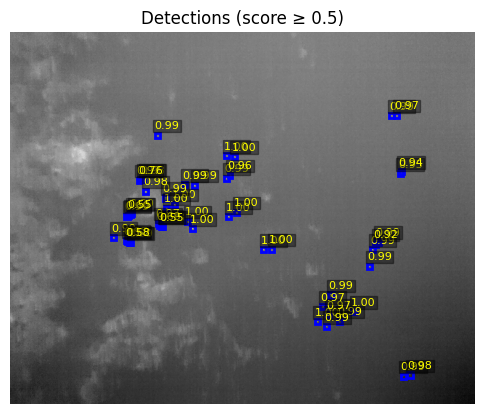

In [69]:
test_image_path = r"C:\Users\LOQ\Downloads\dataset_cv\01_Positive_Image\20180322_102206_869_R.tif"
detect_on_image(model, DEVICE, test_image_path, score_thresh=0.5)


**---------------------------------------------------------------------------------------------------------The END-------------------------------------------------------------------------------------------------------------**